In [1]:
import os
import sqlite3
import json
import random
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm

import torch
import numpy as np
import datasets
import transformers
import wandb
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, DataCollator

/home/glai/anaconda3/envs/subset/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_nth_best(n, db_path):
    try:
        con = sqlite3.connect(db_path)
        cur = con.cursor()
        cur.execute("SELECT * FROM states ORDER BY objective DESC LIMIT 1 OFFSET %d" % n)
        r = cur.fetchone()
    finally:
        con.close()
    return (np.array(json.loads(r[0])), r[1], r[2])


def evaluate(model, val_dataloader, metric, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
        model.eval()
        model.to(device)
        confidence_scores = []
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                logits = outputs.logits
                # get confidence scores
                batch_scores = torch.nn.Softmax()(logits)[:,-1]
                confidence_scores.append(batch_scores)
                # get prediction
                predictions = torch.argmax(logits, dim=-1)
                metric.add_batch(predictions=predictions, references=batch["labels"])
        eval_dict = metric.compute()
        eval_dict["confidence_scores"] = torch.cat(confidence_scores)
        return eval_dict

In [3]:
############# LOAD MODEL #################
PATH = "/home/glai/dev/subset-active-learning/local_bucket/7000_model.pt"
state_dict = torch.load(PATH)
model = AutoModelForSequenceClassification.from_pretrained("roberta-base")
model.load_state_dict(state_dict)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

<All keys matched successfully>

In [4]:
############# GET POOL CONFIDENCE SCORES #################
from subset_active_learning.subset_selection import preprocess
tokenized_sst2 = preprocess.preprocess_sst2(model_card="roberta-base")
sst2_downsample = tokenized_sst2['train'].shuffle(seed=0).select(range(0, 1000))
train_dataloader = torch.utils.data.DataLoader(sst2_downsample, shuffle=False, batch_size=8, pin_memory=True)
evaluation_output = evaluate(model=model, val_dataloader=train_dataloader, metric=datasets.load_metric("accuracy"))

No config specified, defaulting to: sst/default
Reusing dataset sst (/home/glai/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
100%|██████████| 3/3 [00:00<00:00, 888.62it/s]
Loading cached processed dataset at /home/glai/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-e96fff4bcf800b80.arrow
Loading cached processed dataset at /home/glai/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-c19c9b6a9c9f8182.arrow
Loading cached processed dataset at /home/glai/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-8d2a9f8a95240b96.arrow
Loading cached processed dataset at /home/glai/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-0c3dbb722d1f6005.arrow
Loading cache

In [5]:
pool_scores = evaluation_output["confidence_scores"].cpu().numpy()

In [17]:
def get_scores_for_nth_best(n, db_path):
    subset_indices, preds, obj = get_nth_best(n=n, db_path=db_path)
    print(f"{n}th best. Accraucy {obj}")
    subset_confidence_scores = pool_scores[subset_indices]
    return subset_confidence_scores

2000th best. Accraucy 0.71571299


<AxesSubplot: ylabel='Probability'>

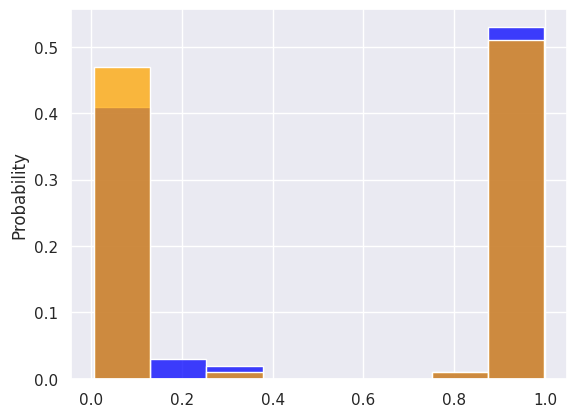

In [21]:
sns.histplot(get_scores_for_nth_best(n=2000, db_path="/home/glai/dev/subset-active-learning/local_bucket/sst_results_diversity_annealing.db"), stat='probability', color='blue', bins=8)
# sns.histplot(pool_scores, stat='probability', color='orange', bins=8)

100th best. Accraucy 0.77747502


<AxesSubplot: ylabel='Probability'>

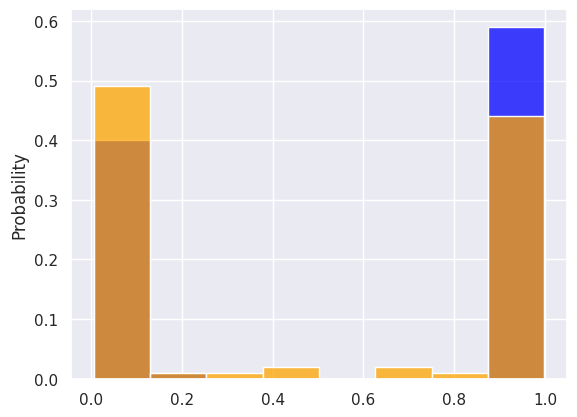

In [22]:
sns.histplot(get_scores_for_nth_best(n=100, db_path="/home/glai/dev/subset-active-learning/local_bucket/sst_results_diversity_annealing.db"), stat='probability', color='blue', bins=8)
sns.histplot(np.random.choice(pool_scores, 100, replace=False), stat='probability', color='orange', bins=8)

0th best. Accraucy 0.78655767


<AxesSubplot: ylabel='Probability'>

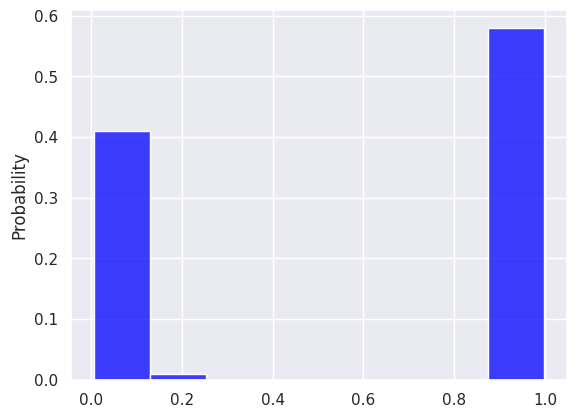

In [19]:
sns.histplot(get_scores_for_nth_best(n=0, db_path="/home/glai/dev/subset-active-learning/local_bucket/sst_results_diversity_annealing.db"), stat='probability', color='blue', bins=8)